In [145]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import utils as ut
import lom


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [146]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [147]:
plothorse = False

Text(0.5, 0.98, 'colours assigned')

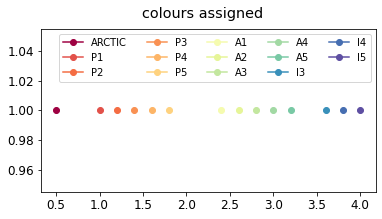

In [148]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan


# w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
# cbar = plt.colorbar(w, ticks=tics)
# t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
# plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

In [149]:

if plothorse:
    
    fact = 0.8

    xl1 = 2100; xl2 = 2600
    yl1 = -600; yl2 = -400
    stit = 'test title'

    fig, axs = plt.subplots(4,4, figsize=(16*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
    axs[15].set_xticklabels([])
    axs[15].set_yticklabels([])



    axs[0].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),'GLOBAL', color = 'k', fontsize = 16)


    for i in range(0,len(regs)):
        axs[i+1].plot(xl1+0.2*(xl2-xl1),yl1+0.8*(yl2-yl1),marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
        axs[i+1].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),regs[i], color = 'k', fontsize = 16)
    for i in range(0,len(regs)+1):
        axs[i].set_xlim([xl1, xl2])
        axs[i].set_ylim([-600,-400])
        axs[i].grid()
    axs[0].legend(fontsize = 10)

    plt.suptitle(stit, fontsize = 20, y = 0.98)
    plt.tight_layout()

# Multimodel tester

In [150]:
regs_g = regs.copy()
regs_g.append('GLOBAL')
print(regs_g)

['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5', 'GLOBAL']


### extract mld

In [151]:
extracthorse = False
if extracthorse:
    yst = 1955; yen = 1960; 
    modlist = ['TOM12_TJ_1ASA','TOM12_RW_TES2','TOM12_RW_3G34', 'TOM12_DW_WE43', 'TOM12_DW_GA01']


    for modnam in modlist:
        dtype = 'grid_T'; #modnam = modlist[r]
        fnam = f'./EXTRACTED/MLD/MLD_{modnam}_{yst}_{yen}.nc'
        print(fnam)

        ylist = ut.make_yearlist(yst, yen, dtype, modnam)
        tdat = xr.open_mfdataset(ylist)

        mldkz5 = np.zeros([15,12])
        mldkz5_m = tdat.mldkz5.groupby('time_counter.month').mean('time_counter').values
        for r in range(0,len(regs)):
            csize_copy = np.copy(csize_broad)
            csize_copy[maskno_broad != regdict[regs[r]]['number']] = 0
            for i in range(0,12):
                mldkz5[r,i] = np.ma.average(mldkz5_m[i,:,:], weights = csize_copy[0,:,:])
        ### get the global one
        for i in range(0,12):
            mldkz5[14,i] = np.ma.average(mldkz5_m[i,:,:], weights = csize_broad[0,:,:])

        mldr10_1 = np.zeros([15,12])
        mldr10_1_m = tdat.mldr10_1.groupby('time_counter.month').mean('time_counter').values
        for r in range(0,len(regs)):
            csize_copy = np.copy(csize_broad)
            csize_copy[maskno_broad != regdict[regs[r]]['number']] = 0
            for i in range(0,12):
                mldr10_1[r,i] = np.ma.average(mldr10_1_m[i,:,:], weights = csize_copy[0,:,:])
        ### get the global one
        for i in range(0,12):
            mldr10_1[14,i] = np.ma.average(mldr10_1_m[i,:,:], weights = csize_broad[0,:,:])        

        data_vars = {'mldkz5':(['region', 'month'], mldkz5,
                                 {'units': 'm'}),
                    'mldr10_1':(['region', 'month'], mldr10_1,
                                 {'units': 'm'}),             
                    }

        coords = {'region': (['region'], regs_g),\
                 'month': (['month'], np.arange(1,13,1))}

        # define global attributes
        attrs = {'made in':'AnalysisRobot/Tester_multimodel_MLD.ipynb',
                }

        # create dataset
        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)
        ds.to_netcdf(fnam)

In [155]:
extracthorse = True
if extracthorse:
    yst = 2010; yen = 2015; 
    modlist = ['TOM12_TJ_1ASA','TOM12_DW_WE43', 'TOM12_DW_GA01']


    for modnam in modlist:
        dtype = 'grid_T'; #modnam = modlist[r]
        fnam = f'./EXTRACTED/MLD/MLD_{modnam}_{yst}_{yen}.nc'
        print(fnam)

        ylist = ut.make_yearlist(yst, yen, dtype, modnam)
        tdat = xr.open_mfdataset(ylist)

        mldkz5 = np.zeros([15,12])
        mldkz5_m = tdat.mldkz5.groupby('time_counter.month').mean('time_counter').values
        for r in range(0,len(regs)):
            csize_copy = np.copy(csize_broad)
            csize_copy[maskno_broad != regdict[regs[r]]['number']] = 0
            for i in range(0,12):
                mldkz5[r,i] = np.ma.average(mldkz5_m[i,:,:], weights = csize_copy[0,:,:])
        ### get the global one
        for i in range(0,12):
            mldkz5[14,i] = np.ma.average(mldkz5_m[i,:,:], weights = csize_broad[0,:,:])

        mldr10_1 = np.zeros([15,12])
        mldr10_1_m = tdat.mldr10_1.groupby('time_counter.month').mean('time_counter').values
        for r in range(0,len(regs)):
            csize_copy = np.copy(csize_broad)
            csize_copy[maskno_broad != regdict[regs[r]]['number']] = 0
            for i in range(0,12):
                mldr10_1[r,i] = np.ma.average(mldr10_1_m[i,:,:], weights = csize_copy[0,:,:])
        ### get the global one
        for i in range(0,12):
            mldr10_1[14,i] = np.ma.average(mldr10_1_m[i,:,:], weights = csize_broad[0,:,:])        

        data_vars = {'mldkz5':(['region', 'month'], mldkz5,
                                 {'units': 'm'}),
                    'mldr10_1':(['region', 'month'], mldr10_1,
                                 {'units': 'm'}),             
                    }

        coords = {'region': (['region'], regs_g),\
                 'month': (['month'], np.arange(1,13,1))}

        # define global attributes
        attrs = {'made in':'AnalysisRobot/Tester_multimodel_MLD.ipynb',
                }

        # create dataset
        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)
        ds.to_netcdf(fnam)

./EXTRACTED/MLD/MLD_TOM12_TJ_1ASA_2010_2015.nc
./EXTRACTED/MLD/MLD_TOM12_DW_WE43_2010_2015.nc
./EXTRACTED/MLD/MLD_TOM12_DW_GA01_2010_2015.nc


# A) Figures showing monthly MLD by region as line plots:

These plots show 

In [152]:
reload(lom)

<module 'lom' from '/gpfs/scratch/mep22dku/AnalysisRobot/lom.py'>

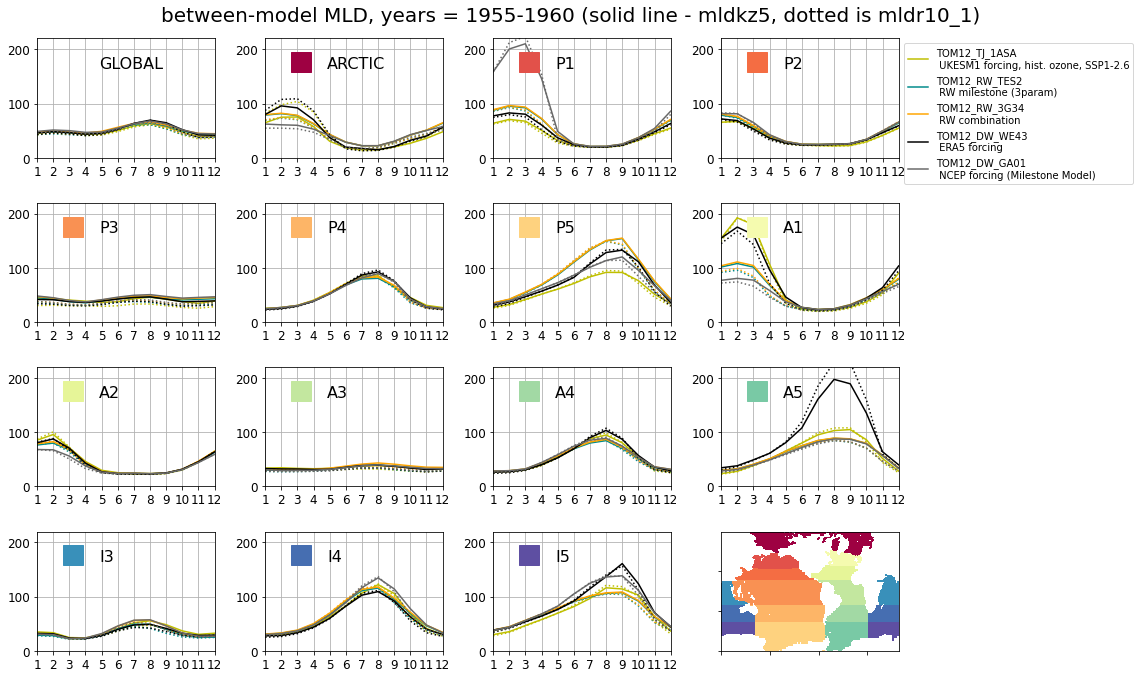

In [156]:
fact = 0.8
yst = 1955; yen = 1960
xl1 = 1; xl2 = 12
yl1 = 0; yl2 = 220
stit = f'between-model MLD, years = {yst}-{yen} (solid line - mldkz5, dotted is mldr10_1)'

fig, axs = plt.subplots(4,4, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

modlist = ['TOM12_TJ_1ASA','TOM12_RW_TES2','TOM12_RW_3G34', 'TOM12_DW_WE43', 'TOM12_DW_GA01']
for m in range(0, len(modlist)):
    modnam = modlist[m]
    tmod =  xr.open_dataset(f'./EXTRACTED/MLD/MLD_{modnam}_{yst}_{yen}.nc')
    desc = (lom.mod[modnam]['desc'])
    tcol = (lom.mod[modnam]['color'])
    for i in range(0,len(regs)):
        axs[i+1].plot(np.arange(1,13,1), tmod['mldkz5'][i,:], color = tcol, label = f'{modnam} \n {desc}')
    axs[0].plot(np.arange(1,13,1), tmod['mldkz5'][14,:], color = tcol, label = desc)
    for i in range(0,len(regs)):
        axs[i+1].plot(np.arange(1,13,1), tmod['mldr10_1'][i,:], color = tcol, linestyle = ':')
    axs[0].plot(np.arange(1,13,1), tmod['mldr10_1'][14,:], color = tcol, linestyle = ':')




axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])
axs[0].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),'GLOBAL', color = 'k', fontsize = 16)


for i in range(0,len(regs)):
    axs[i+1].plot(xl1+0.2*(xl2-xl1),yl1+0.8*(yl2-yl1),marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),regs[i], color = 'k', fontsize = 16)
for i in range(0,len(regs)+1):
    axs[i].set_xlim([xl1, xl2])
    axs[i].set_ylim([-yl1,yl2])
    axs[i].set_xticks(np.arange(1,13,1))
    
    axs[i].grid()
axs[3].legend(fontsize = 10, bbox_to_anchor = [1,1])

plt.suptitle(stit, fontsize = 20, y = 0.98)
plt.tight_layout()

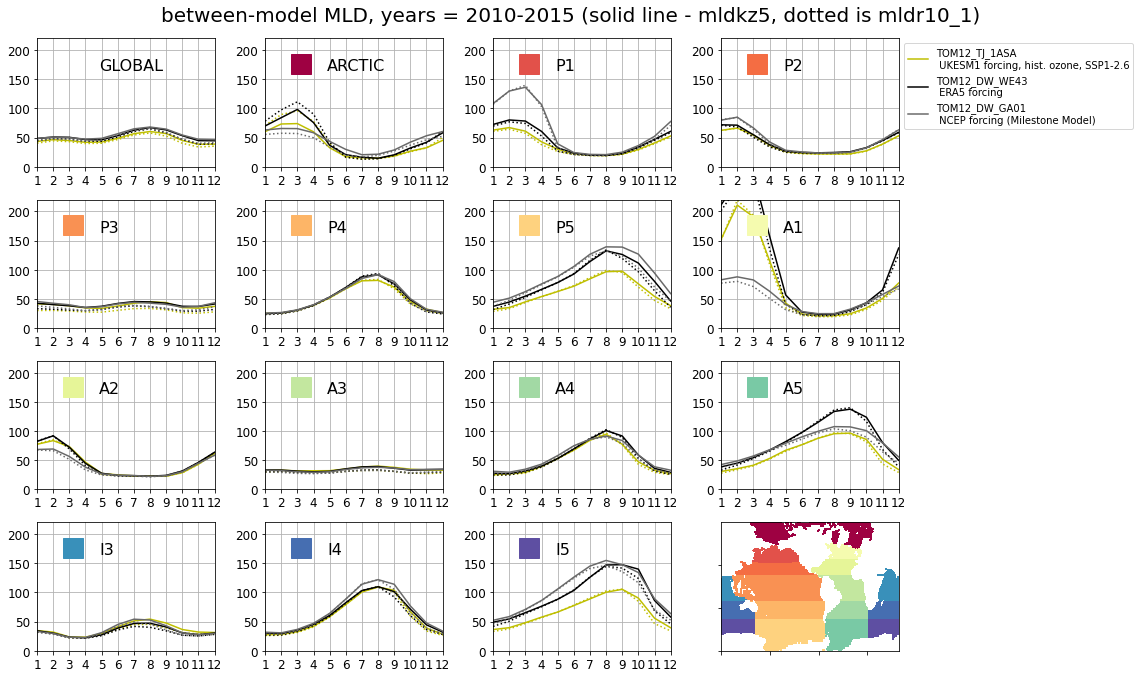

In [158]:
yst = 2010; yen = 2015; 
xl1 = 1; xl2 = 12
yl1 = 0; yl2 = 220
stit = f'between-model MLD, years = {yst}-{yen} (solid line - mldkz5, dotted is mldr10_1)'

fig, axs = plt.subplots(4,4, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

modlist = ['TOM12_TJ_1ASA', 'TOM12_DW_WE43', 'TOM12_DW_GA01']
for m in range(0, len(modlist)):
    modnam = modlist[m]
    tmod =  xr.open_dataset(f'./EXTRACTED/MLD/MLD_{modnam}_{yst}_{yen}.nc')
    desc = (lom.mod[modnam]['desc'])
    tcol = (lom.mod[modnam]['color'])
    for i in range(0,len(regs)):
        axs[i+1].plot(np.arange(1,13,1), tmod['mldkz5'][i,:], color = tcol, label = f'{modnam} \n {desc}')
    axs[0].plot(np.arange(1,13,1), tmod['mldkz5'][14,:], color = tcol, label = desc)
    for i in range(0,len(regs)):
        axs[i+1].plot(np.arange(1,13,1), tmod['mldr10_1'][i,:], color = tcol, linestyle = ':')
    axs[0].plot(np.arange(1,13,1), tmod['mldr10_1'][14,:], color = tcol, linestyle = ':')




axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])
axs[0].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),'GLOBAL', color = 'k', fontsize = 16)


for i in range(0,len(regs)):
    axs[i+1].plot(xl1+0.2*(xl2-xl1),yl1+0.8*(yl2-yl1),marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(xl1+0.35*(xl2-xl1),yl1+0.75*(yl2-yl1),regs[i], color = 'k', fontsize = 16)
for i in range(0,len(regs)+1):
    axs[i].set_xlim([xl1, xl2])
    axs[i].set_ylim([-yl1,yl2])
    axs[i].set_xticks(np.arange(1,13,1))
    
    axs[i].grid()
axs[3].legend(fontsize = 10, bbox_to_anchor = [1,1])

plt.suptitle(stit, fontsize = 20, y = 0.98)
plt.tight_layout()

## B) how different is each model from the ncep-forcing milestone model? yearly map view

3


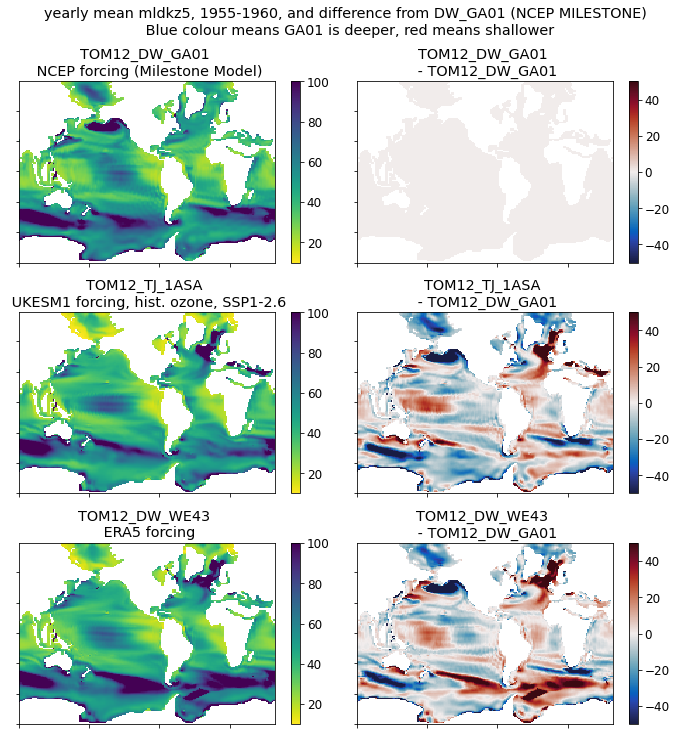

In [162]:
yst = 1955; yen = 1960; 
modlist = ['TOM12_DW_GA01', 'TOM12_TJ_1ASA', 'TOM12_DW_WE43']
print(len(modlist))
fig, axs = plt.subplots(3,2, figsize=(12*fact, 13*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

## get DW_GA01 model:

dtype = 'grid_T'; modnam = 'TOM12_DW_GA01'
ylist = ut.make_yearlist(yst, yen, dtype, modnam)
tdat = xr.open_mfdataset(ylist)
mldkz5_GA01 = np.nanmean(tdat.mldkz5.resample(time_counter="Y").mean().values, axis = 0)
mldkz5_GA01[mldkz5_GA01 == 0] = np.nan

for r in range(0, 3):

    yst = 1955; yen = 1960; dtype = 'grid_T'; modnam = modlist[r]
    ylist = ut.make_yearlist(yst, yen, dtype, modnam)
    tdat = xr.open_mfdataset(ylist)

    mldkz5 = np.nanmean(tdat.mldkz5.resample(time_counter="Y").mean().values, axis = 0)
    mldkz5[mldkz5 == 0] = np.nan
    t = axs[r*2].pcolormesh(mldkz5, vmin = 10, vmax = 100, cmap = 'viridis_r')
    desc = (lom.mod[modnam]['desc'])
    axs[r*2].set_title(f'{modnam} \n {desc}')
    axs[r*2].set_xticklabels([])
    axs[r*2].set_yticklabels([])
    plt.colorbar(t, ax = axs[r*2])
    
    t = axs[r*2+1].pcolormesh(mldkz5-mldkz5_GA01, vmin = -50, vmax = 50, cmap = cm.balance)
    axs[r*2+1].set_title(f'{modnam} \n - TOM12_DW_GA01')
    axs[r*2+1].set_xticklabels([])
    axs[r*2+1].set_yticklabels([])
    plt.colorbar(t, ax = axs[r*2+1])

plt.suptitle('yearly mean mldkz5, 1955-1960, and difference from DW_GA01 (NCEP MILESTONE) \n Blue colour means GA01 is deeper, red means shallower')
plt.tight_layout()

3


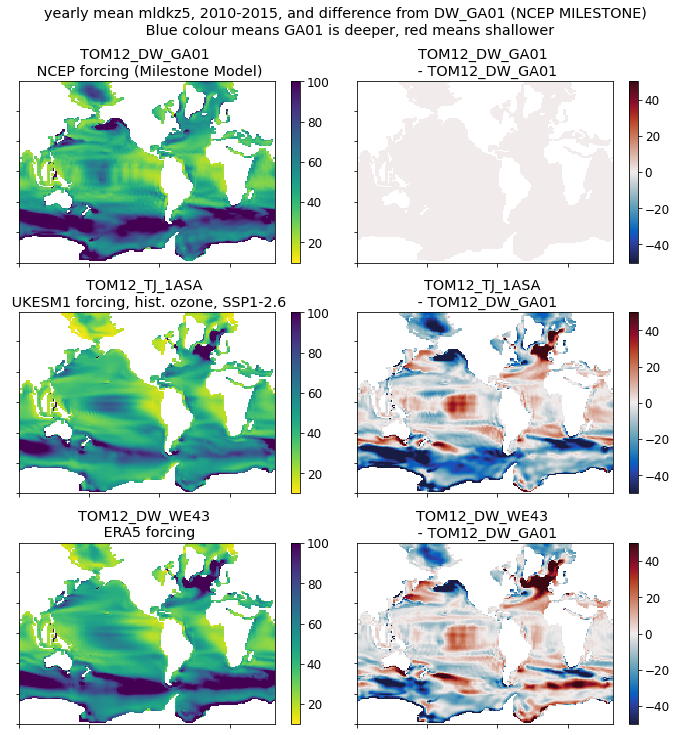

In [164]:
yst = 2010; yen = 2015; 
modlist = ['TOM12_DW_GA01', 'TOM12_TJ_1ASA','TOM12_DW_WE43']
print(len(modlist))
fig, axs = plt.subplots(3,2, figsize=(12*fact, 13*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

## get DW_GA01 model:

dtype = 'grid_T'; modnam = 'TOM12_DW_GA01'
ylist = ut.make_yearlist(yst, yen, dtype, modnam)
tdat = xr.open_mfdataset(ylist)
mldkz5_GA01 = np.nanmean(tdat.mldkz5.resample(time_counter="Y").mean().values, axis = 0)
mldkz5_GA01[mldkz5_GA01 == 0] = np.nan

for r in range(0, 3):

    dtype = 'grid_T'; modnam = modlist[r]
    ylist = ut.make_yearlist(yst, yen, dtype, modnam)
    tdat = xr.open_mfdataset(ylist)

    mldkz5 = np.nanmean(tdat.mldkz5.resample(time_counter="Y").mean().values, axis = 0)
    mldkz5[mldkz5 == 0] = np.nan
    t = axs[r*2].pcolormesh(mldkz5, vmin = 10, vmax = 100, cmap = 'viridis_r')
    desc = (lom.mod[modnam]['desc'])
    axs[r*2].set_title(f'{modnam} \n {desc}')
    axs[r*2].set_xticklabels([])
    axs[r*2].set_yticklabels([])
    plt.colorbar(t, ax = axs[r*2])
    
    t = axs[r*2+1].pcolormesh(mldkz5-mldkz5_GA01, vmin = -50, vmax = 50, cmap = cm.balance)
    axs[r*2+1].set_title(f'{modnam} \n - TOM12_DW_GA01')
    axs[r*2+1].set_xticklabels([])
    axs[r*2+1].set_yticklabels([])
    plt.colorbar(t, ax = axs[r*2+1])

plt.suptitle(f'yearly mean mldkz5, {yst}-{yen}, and difference from DW_GA01 (NCEP MILESTONE) \n Blue colour means GA01 is deeper, red means shallower')
plt.tight_layout()